In [10]:
#optiver volatility prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')

In [11]:
train = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/Optiver/train.csv')
test = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/Optiver/test.csv')
order_book = pd.read_parquet('/Users/ericp/OneDrive/Documents/GitHub/Optiver/book_train.parquet/stock_id=0')
trade_book = pd.read_parquet('/Users/ericp/OneDrive/Documents/GitHub/Optiver/trade_train.parquet/stock_id=0')

In [8]:
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [9]:
test.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [12]:
stock_id = '0'
book_example = order_book[order_book['time_id'] == 5]
book_example['stock_id'] = stock_id
trade_example = trade_book[trade_book['time_id'] == 5]
trade_example['stock_id'] = stock_id

In [17]:
book_example.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wt_avg
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,1.001434
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,1.001448
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,1.001448
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443


In [14]:
trade_example.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [16]:
book_example['wt_avg'] = (book_example['bid_price1'] * book_example['ask_size1'] + book_example['ask_price1'] * book_example['bid_size1'])/ (book_example['bid_size1'] + book_example['ask_size1'])

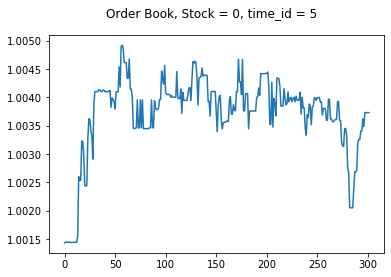

In [19]:
f, axs = plt.subplots(1)
f.suptitle('Order Book, Stock = 0, time_id = 5')
axs.plot(book_example['wt_avg'])

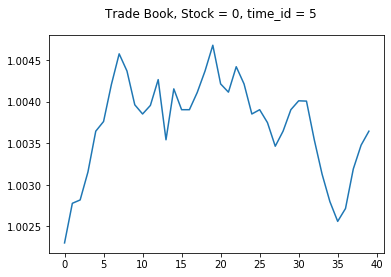

In [21]:
f, axs = plt.subplots(1)
f.suptitle('Trade Book, Stock = 0, time_id = 5')
axs.plot(trade_example['price'])

In [23]:
#create log diffs
def logDiff(stock_prices):
    return np.log(stock_prices).diff()

In [24]:
book_example['logDifferences'] = logDiff(book_example['wt_avg'])
book_example = book_example[book_example['logDifferences'].notnull()]
trade_example['logDifferences'] = logDiff(trade_example['price'])
trade_example = trade_example[trade_example['logDifferences'].notnull()]

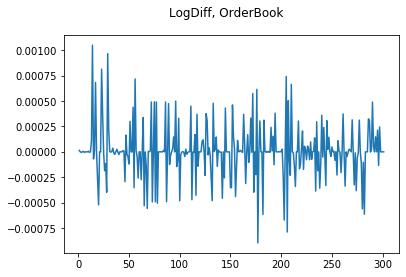

In [25]:
f, axs = plt.subplots(1)
f.suptitle('LogDiff, OrderBook')
axs.plot(book_example['logDifferences'])

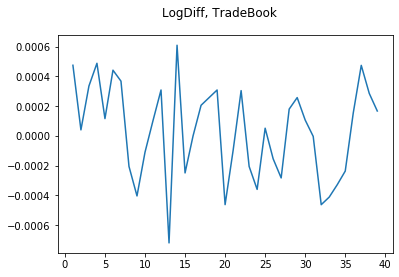

In [26]:
f, axs = plt.subplots(1)
f.suptitle('LogDiff, TradeBook')
axs.plot(trade_example['logDifferences'])

In [27]:
#create realized vols for each time / stock price
def realized_vol(log_diffs):
    return np.sqrt(np.sum(log_diffs ** 2))

In [29]:
print('Realized vol for Stock 0 over Time Period 5 order_book is: {}'.format(realized_vol(book_example['logDifferences'])))
print('Realized vol for Stock 0 over Time Period 5 trade_book is: {}'.format(realized_vol(trade_example['logDifferences'])))

Realized vol for Stock 0 over Time Period 5 order_book is: 0.004499364172786558
Realized vol for Stock 0 over Time Period 5 trade_book is: 0.0020058895461261272


In [30]:
def RMSPE(vols, truth):         
    return np.sqrt(np.sum(np.mean(np.square((vols - truth)/truth))))   

In [31]:
orderPath = glob.glob('/Users/ericp/OneDrive/Documents/GitHub/Optiver/book_train.parquet/*')
predictionColumn = 'target'

In [56]:
def orderBookVol(file, predictionColumn):
    #read file
    order_book = pd.read_parquet(file)
    #create variable for stock_id
    stock_id = file.split('=')[1]
    #create wt avg price
    order_book['wt_avg'] = (order_book['bid_price1'] * order_book['ask_size1'] + 
                            order_book['ask_price1'] * order_book['bid_size1']) / (order_book['bid_size1'] + order_book['ask_size1'])
    #create logDiff
    order_book['logDifferences'] = order_book.groupby(['time_id'])['wt_avg'].apply(logDiff)
    #get rid of NaNs
    order_book = order_book[order_book['logDifferences'].notnull()]
    #create vol estimate
    response = pd.DataFrame(data = order_book.groupby(['time_id'])['logDifferences'].apply(realized_vol)).reset_index()
    response = response.rename(columns = {'logDifferences': predictionColumn})
    #add row_id
    response['row_id'] = response['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    return response[['row_id', predictionColumn]]
                                                                                       
                                                                                       

In [57]:
ans = orderBookVol(orderPath[0], predictionColumn)

In [60]:
#loop thru all files
def loopThruFiles(path, predictionColumn):
    response = pd.DataFrame()
    for file in path:
        answer = orderBookVol(file, predictionColumn)
        response = pd.concat([response, answer], axis = 0)
    return response
        

In [61]:
naive_model = loopThruFiles(orderPath, predictionColumn)

In [62]:
naive_model.head()

,row_id,target
0,0-5,0.004499
1,0-11,0.001204
2,0-16,0.002369
3,0-31,0.002574
4,0-62,0.001894


In [63]:
naive_model.shape

(428932, 2)

In [ ]:
naivemodel.to_csv('submission.csv', index = False)